In [1]:
import itertools, copy
import json
import numpy as np
import scipy.misc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from lib import *

In [2]:
counters = [count_kmers_proteome(human, k) for k in range(1, 6)]

In [19]:
df0 = counter_to_df(counters[0])
df0 = df0[~df0['seq'].str.contains('U|B|X|Z')]
aas = ''.join(sorted(df0['seq']))
df0 = df0.set_index('seq')
print(len(aas), aas)

20 ACDEFGHIKLMNPQRSTVWY


In [23]:
with open('../data/triplet-human.json', 'r') as f:
    tripletparams = json.load(f)

In [5]:
print(10**loglikelihood_independent('ACL', **tripletparams))
print(10**loglikelihood_mc('ACL', **tripletparams))
print(10**loglikelihood_triplet('ACL', **tripletparams))

0.0001606189778362446
0.00013991001867381722
0.00014523024562271262


In [6]:
df1 = counter_to_df(counters[1])
df1 = df1[~df1['seq'].str.contains('U|B|X|Z')]
df1 = df1.set_index('seq')

In [7]:
dfgap1 = counter_to_df(count_kmers_proteome(human, 2, gap=1))
dfgap1 = dfgap1[~dfgap1['seq'].str.contains('U|B|X|Z')]
dfgap1 = dfgap1.set_index('seq')

In [8]:
dfgap2 = counter_to_df(count_kmers_proteome(human, 2, gap=2))
dfgap2 = dfgap2[~dfgap2['seq'].str.contains('U|B|X|Z')]
dfgap2 = dfgap2.set_index('seq')

In [16]:
def fit_ising(f1, f2s, niter=1, nmcmc=1e6, epsilon=0.1, Jk=None):
    h = np.log(f1['freq']).to_dict()
    aas_arr = np.array(list(aminoacids))
    if Jk is None:
        J0 = np.zeros((len(aminoacids), len(aminoacids)))
        J0 = pd.DataFrame(np.asarray(J0), index=list(aminoacids), columns=list(aminoacids)).to_dict()
        Jk = [J0]
        for gap in range(1, len(f2s)):
            Jk.append(copy.deepcopy(J0))
    for i in range(niter):
        jump = lambda x: ''.join(np.random.choice(aas_arr, size=6))
        x0 = jump(None)
        samples = mcmcsampler(x0, lambda x: energy_ising(x, h, Jk), jump, nmcmc)
        for gap in range(len(f2s)):
            m = f2s[gap].merge(counter_to_df(count_kmers_iterable(samples, 2, gap=gap)), left_index=True, right_on='seq')
            m['logfold'] = np.log(m['freq_x']/m['freq_y'])
            print(i, gap, np.mean(np.abs(m['logfold'])))
            for idx, row in m.iterrows():
                logfold = row['logfold']
                aa1 = row['seq'][0]
                aa2 = row['seq'][1]
                Jk[gap][aa1][aa2] += logfold * epsilon
    return h, Jk

In [24]:
h, Jk = fit_ising(df0, [df1, dfgap1, dfgap2], nmcmc=1e6, niter=30, epsilon=0.2)

0 0 0.10390149492621878
0 1 0.08506952213270942
0 2 0.0871671998830506
1 0 0.08353738487343654
1 1 0.06741244470162884
1 2 0.06928123319387797
2 0 0.06644173106831572
2 1 0.055742585847317894
2 2 0.05686145910586655
3 0 0.053774233845202274
3 1 0.0448193021432373
3 2 0.04726459923235149
4 0 0.045409584145743025
4 1 0.03983210796724204
4 2 0.03983635061288251
5 0 0.036979936277176474
5 1 0.03310924224974998
5 2 0.03458446779591976
6 0 0.03240491636020167
6 1 0.02783106258251957
6 2 0.031094654597346123
7 0 0.027638405175349767
7 1 0.025891626601083774
7 2 0.02896339149932814
8 0 0.023751808586320564
8 1 0.022741262326061013
8 2 0.02570100330521192
9 0 0.02309036489063383
9 1 0.0222436812366235
9 2 0.025462449123834698
10 0 0.01927161904189125
10 1 0.02120920221259377
10 2 0.026484051849744915
11 0 0.0213269781882524
11 1 0.02057465933017684
11 2 0.022573485075454033
12 0 0.020523828347189545
12 1 0.020216159296687602
12 2 0.024430209771387754
13 0 0.019931572703004052
13 1 0.02006456642

In [25]:
jump = lambda x: ''.join(np.random.choice(list(aminoacids), size=8))
x0 = jump(0)
samples = mcmcsampler(x0, lambda x: energy_ising(x, h, Jk), jump, 1e6)

0.008313705223201542

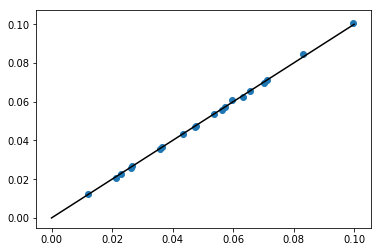

In [26]:
dfm0 = df0.merge(counter_to_df(count_kmers_iterable(samples, 1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.1)
plt.plot(x, x, 'k')
plt.scatter(dfm0['freq_x'], dfm0['freq_y'])
dfm0['logfold'] = np.log(dfm0['freq_x']/dfm0['freq_y'])
np.abs(dfm0['logfold']).mean()

0.02115148677903165

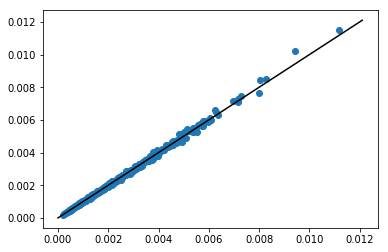

In [27]:
dfm1 = df1.merge(counter_to_df(count_kmers_iterable(samples, 2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfm1['freq_x'], dfm1['freq_y'])
dfm1['logfold'] = np.log(dfm1['freq_x']/dfm1['freq_y'])
np.abs(dfm1['logfold']).mean()

0.02327466488602673

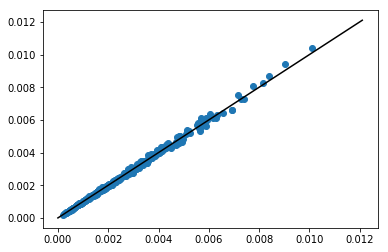

In [28]:
dfmgap1 = dfgap1.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=1)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap1['freq_x'], dfmgap1['freq_y'])
dfmgap1['logfold'] = np.log(dfmgap1['freq_x']/dfmgap1['freq_y'])
np.abs(dfmgap1['logfold']).mean()

0.024525493631249864

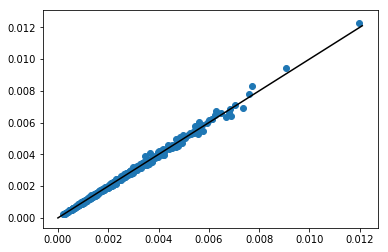

In [29]:
dfmgap2 = dfgap2.merge(counter_to_df(count_kmers_iterable(samples, 2, gap=2)), left_index=True, right_on='seq')
x = np.linspace(0.0, 0.11**2)
plt.plot(x, x, 'k')
plt.scatter(dfmgap2['freq_x'], dfmgap2['freq_y'])
dfmgap2['logfold'] = np.log(dfmgap2['freq_x']/dfmgap2['freq_y'])
np.abs(dfmgap2['logfold']).mean()

In [30]:
dfJk = [pd.DataFrame.from_dict(J) for J in Jk]

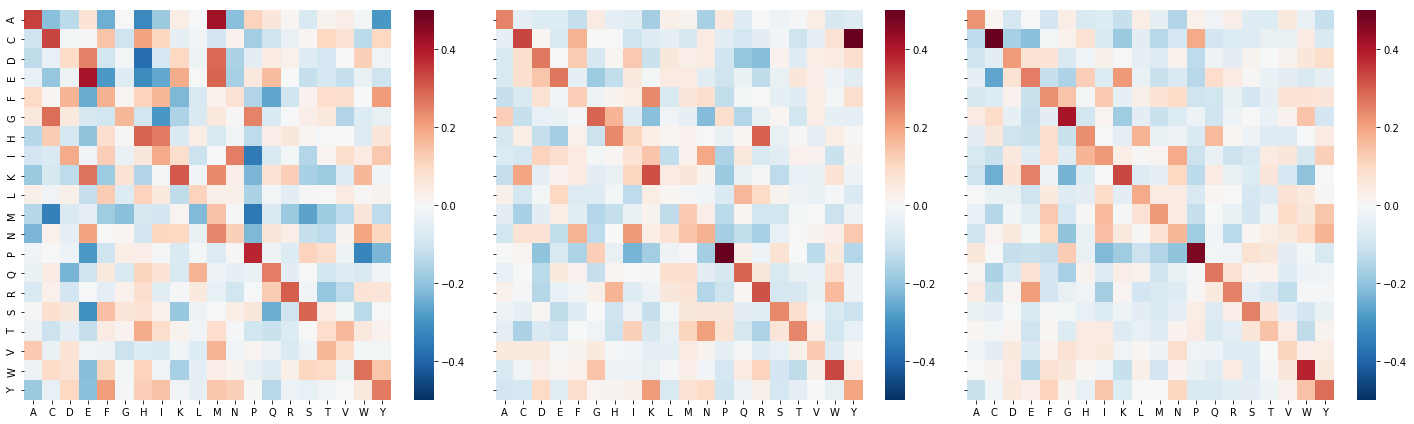

In [31]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=len(dfJk), sharex=True, sharey=True)
for i, dfJ in enumerate(dfJk):
    sns.heatmap(dfJ, vmin=-0.5, vmax=0.5, cmap='RdBu_r', ax=axes[i])
fig.tight_layout()

In [50]:
k = 4
#kmers = list(itertools.product(aminoacids, repeat=k))
df = counter_to_df(count_kmers_proteome(human, k))
df = df[~df['seq'].str.contains('U|B|X|Z')]
df = df.set_index('seq')
kmers = df.index
exp = np.array([float(df.loc[''.join(s)]) for s in kmers])
Z = np.exp(scipy.special.logsumexp([-energy_ising(s, h, Jk) for s in itertools.product(aminoacids, repeat=k)]))
ising = np.exp([-energy_ising(s, h, Jk) for s in kmers])/Z
tri = np.array([10**(loglikelihood_triplet(s, **tripletparams)) for s in kmers])
mc = np.array([10**(loglikelihood_mc(s, **tripletparams)) for s in kmers])
ind = np.array([10**(loglikelihood_independent(s, **tripletparams)) for s in kmers])
rising = np.corrcoef(ising, exp)[1, 0]
rind = np.corrcoef(ind, exp)[1, 0]
rtri = np.corrcoef(tri, exp)[1, 0]
rtri, rising, np.corrcoef(mc, exp)[1, 0], rind

(0.9396881112520182,
 0.9290970145146863,
 0.8821731898433341,
 0.8232060016090639)

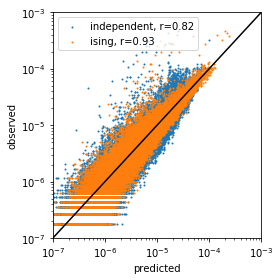

In [53]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(ind, exp, s=1, label='independent, r=%1.2f'%rind)
#plt.scatter(mc, exp, s=1)
plt.scatter(ising, exp, s=1, label='ising, r=%1.2f'%rising)
x = np.logspace(-7, -3)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.plot(x, x, 'k')
plt.xlim(min(x), max(x))
plt.ylim(min(x), max(x))
plt.legend()
plt.xscale('log')
plt.yscale('log')
fig.tight_layout()
fig.savefig('plots/modelfits-4mer-ising.png', dpi=300)

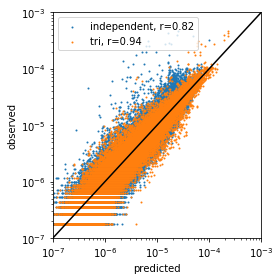

In [52]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(ind, exp, s=1, label='independent, r=%1.2f'%rind)
#plt.scatter(mc, exp, s=1)
plt.scatter(tri, exp, s=1, label='tri, r=%1.2f'%rtri)
x = np.logspace(-7, -3)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.plot(x, x, 'k')
plt.xlim(min(x), max(x))
plt.ylim(min(x), max(x))
plt.legend()
plt.xscale('log')
plt.yscale('log')
fig.tight_layout()
fig.savefig('plots/modelfits-4mer-tri.png', dpi=300)

In [ ]:
pd.DataFrame(index=[key for key in h], data=[h[key] for key in h], columns=['h'])

In [ ]:
itertools.repeat?

In [ ]:
doublets = [''.join(s) for s in itertools.product(list(aminoacids), repeat=2)]

In [ ]:
df = pd.DataFrame(index=doublets, data=[Jk[0][s[0]][s[1]] for s in doublets], columns=['J0'])
for i in range(1, len(Jk)):
    df['J%g'%i] = [Jk[i][s[0]][s[1]] for s in doublets]

In [ ]:
from functools import reduce

In [ ]:
df

In [ ]:
reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), [pd.DataFrame.from_dict(
    {i+j: Jk[gap][i][j] for i in Jk[gap].keys() for j in Jk[gap][i].keys()},
    orient='index')
           for gap in range(len(Jk))])

In [ ]:
pd.merge?